In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="aszNzqpyyqoGBK5MREHi")
project = rf.workspace("thrisha").project("number-plate-detection-wzc7s")
version = project.version(1)
dataset = version.download("yolov8")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Number-Plate-Detection-1 in yolov8:: 100%|██████████| 1077/1077 [00:00<00:00, 5786.21it/s]


In [2]:
!nvidia-smi

Fri Jan 17 11:08:15 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

In [4]:
train_img= "/content/Number-Plate-Detection-1/train/images"
train_lab= "/content/Number-Plate-Detection-1/train/labels"

test_img= "/content/Number-Plate-Detection-1/valid/images"
test_lab= "/content/Number-Plate-Detection-1/valid/labels"

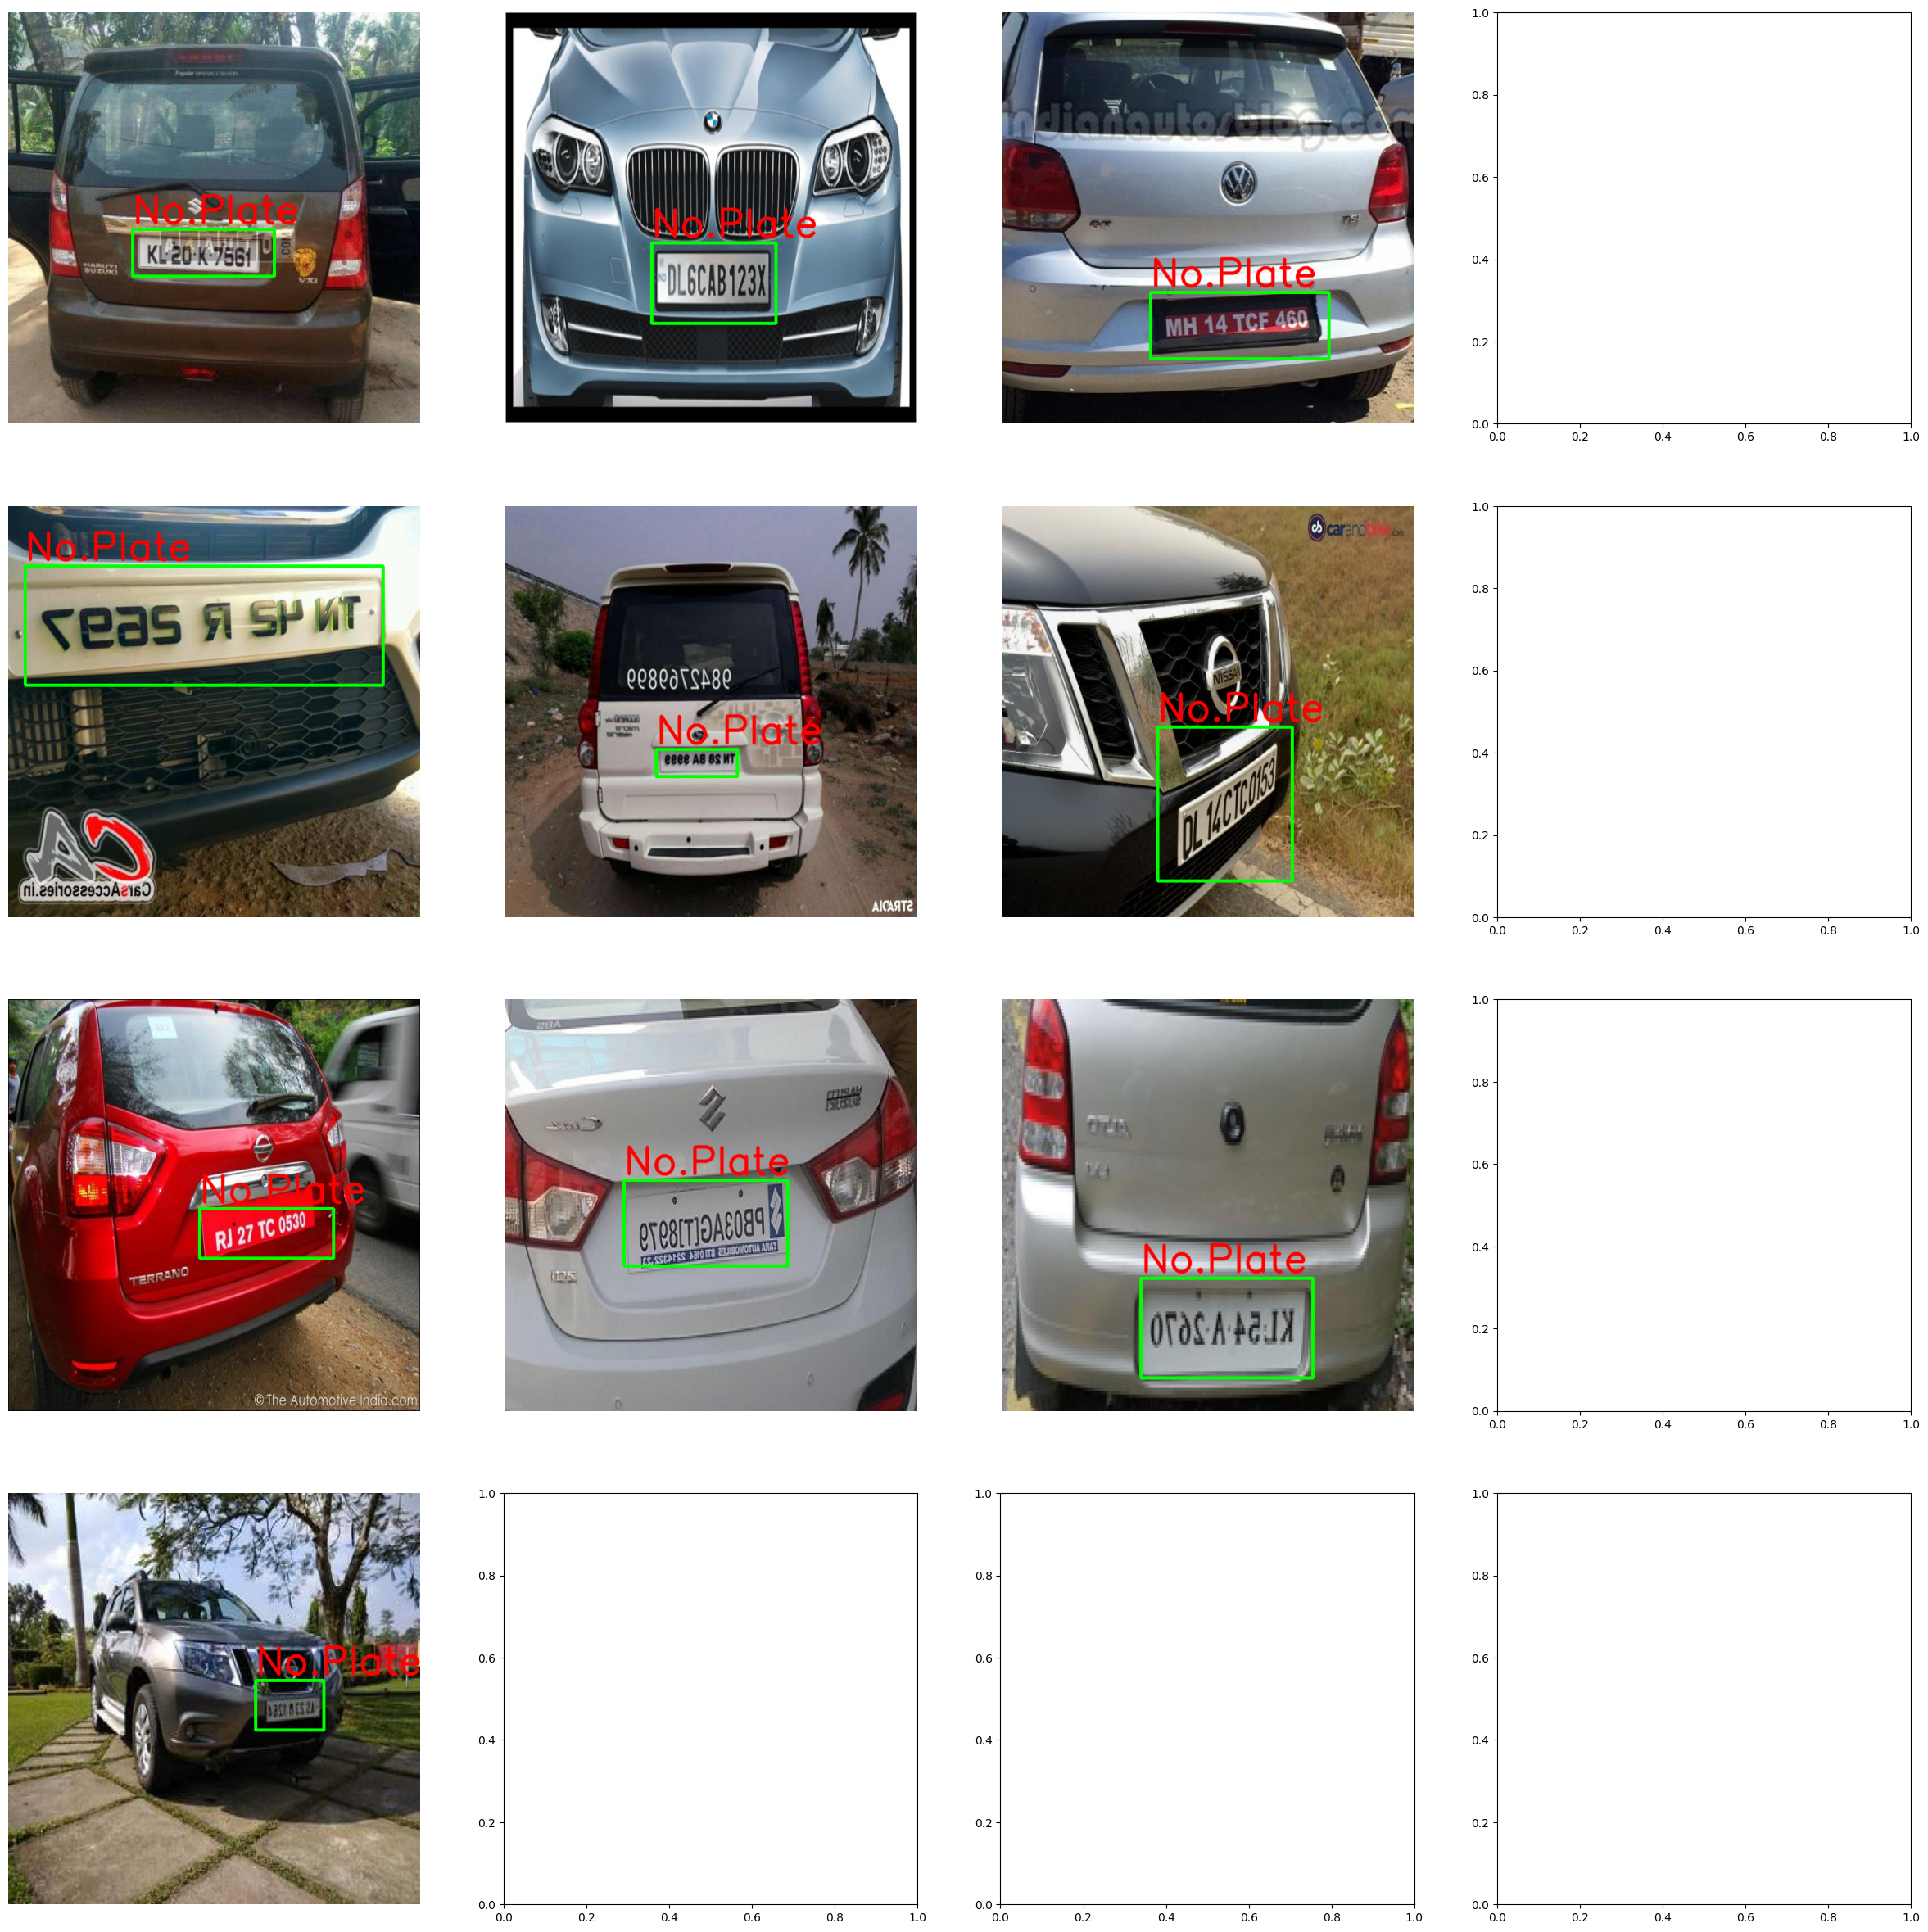

In [8]:
img_dir = train_img
label_dir = train_lab

img_files = os.listdir(img_dir)
ran_img = random.sample(img_files, 10)

fig, axs = plt.subplots(4, 4, figsize=(30,30))

for i, image_file in enumerate(ran_img):
    row = i // 3
    col = i % 3
    image_path = os.path.join(img_dir, image_file)
    image = cv2.imread(image_path)

    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(label_dir, label_file)

    if not os.path.exists(label_path):
        print(f"Label file not found for {image_file}")
        axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[row, col].axis('off')
        continue

    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width / 2) * image.shape[1])
        y_min = int((y_center - height / 2) * image.shape[0])
        x_max = int((x_center + width / 2) * image.shape[1])
        y_max = int((y_center + height / 2) * image.shape[0])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)
        cv2.putText(image, "No.Plate" , (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0 , 255), 3, cv2.LINE_AA)

    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()


TRAIN A MODEL

In [9]:
# Install the ultralytics package from PyPI
! pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.1/910.1 kB 24.3 MB/s eta 0:00:00


In [11]:
!yolo task=detect mode=train model=yolov8s.pt data=/content/Number-Plate-Detection-1/data.yaml epochs=60 imgsz=416 plots=True

100% 21.5M/21.5M [00:00<00:00, 215MB/s]
Ultralytics 8.3.62 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/Number-Plate-Detection-1/data.yaml, epochs=60, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save

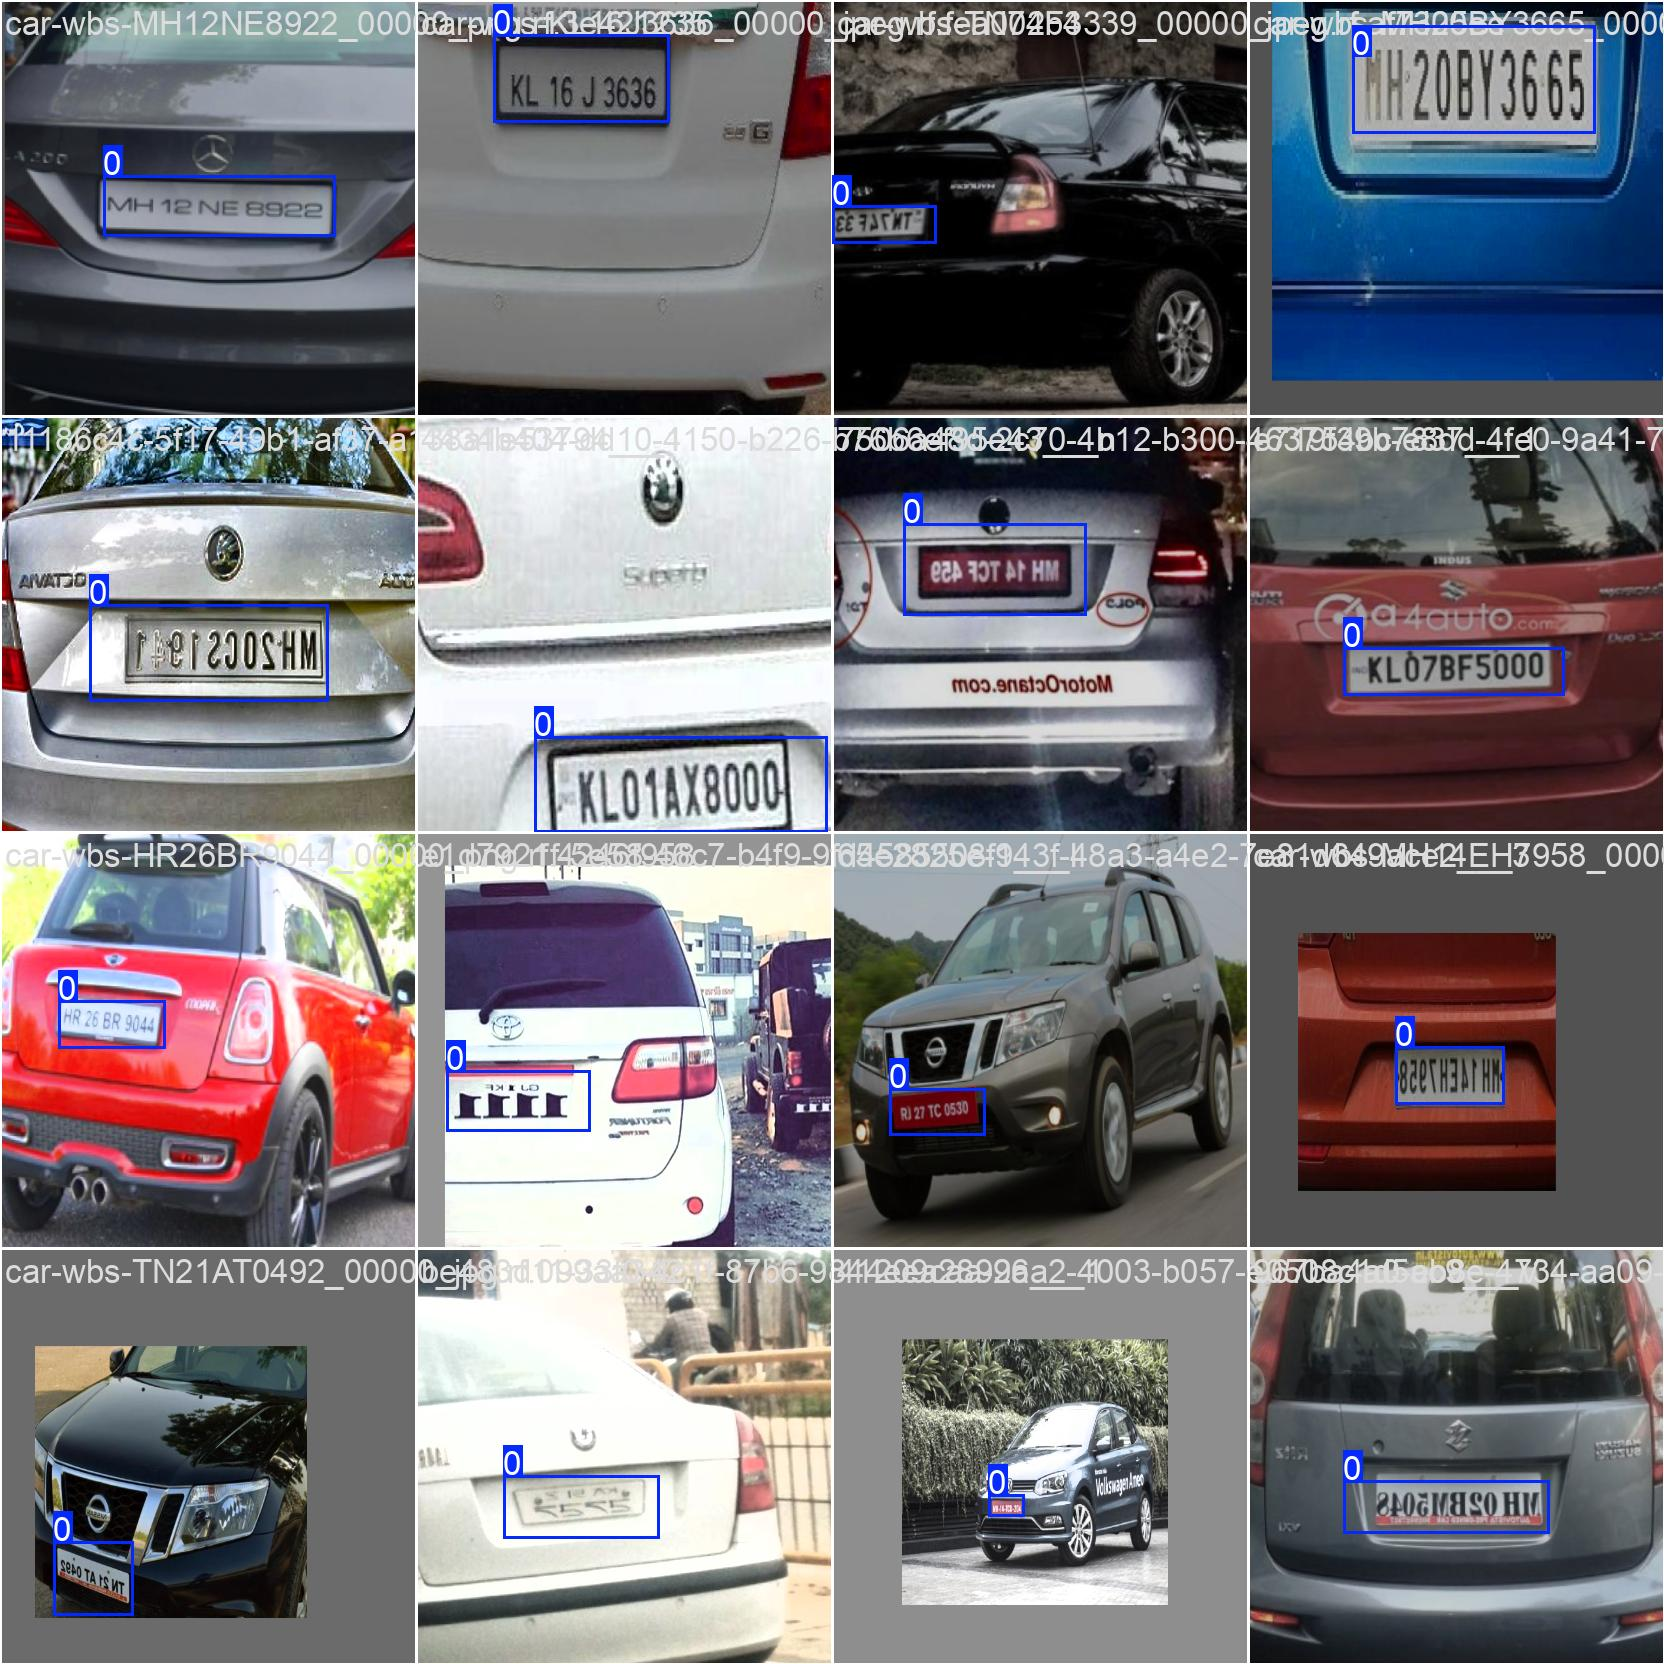

In [13]:
from IPython.display import Image
Image(filename="/content/runs/detect/train/train_batch1300.jpg", width=600)

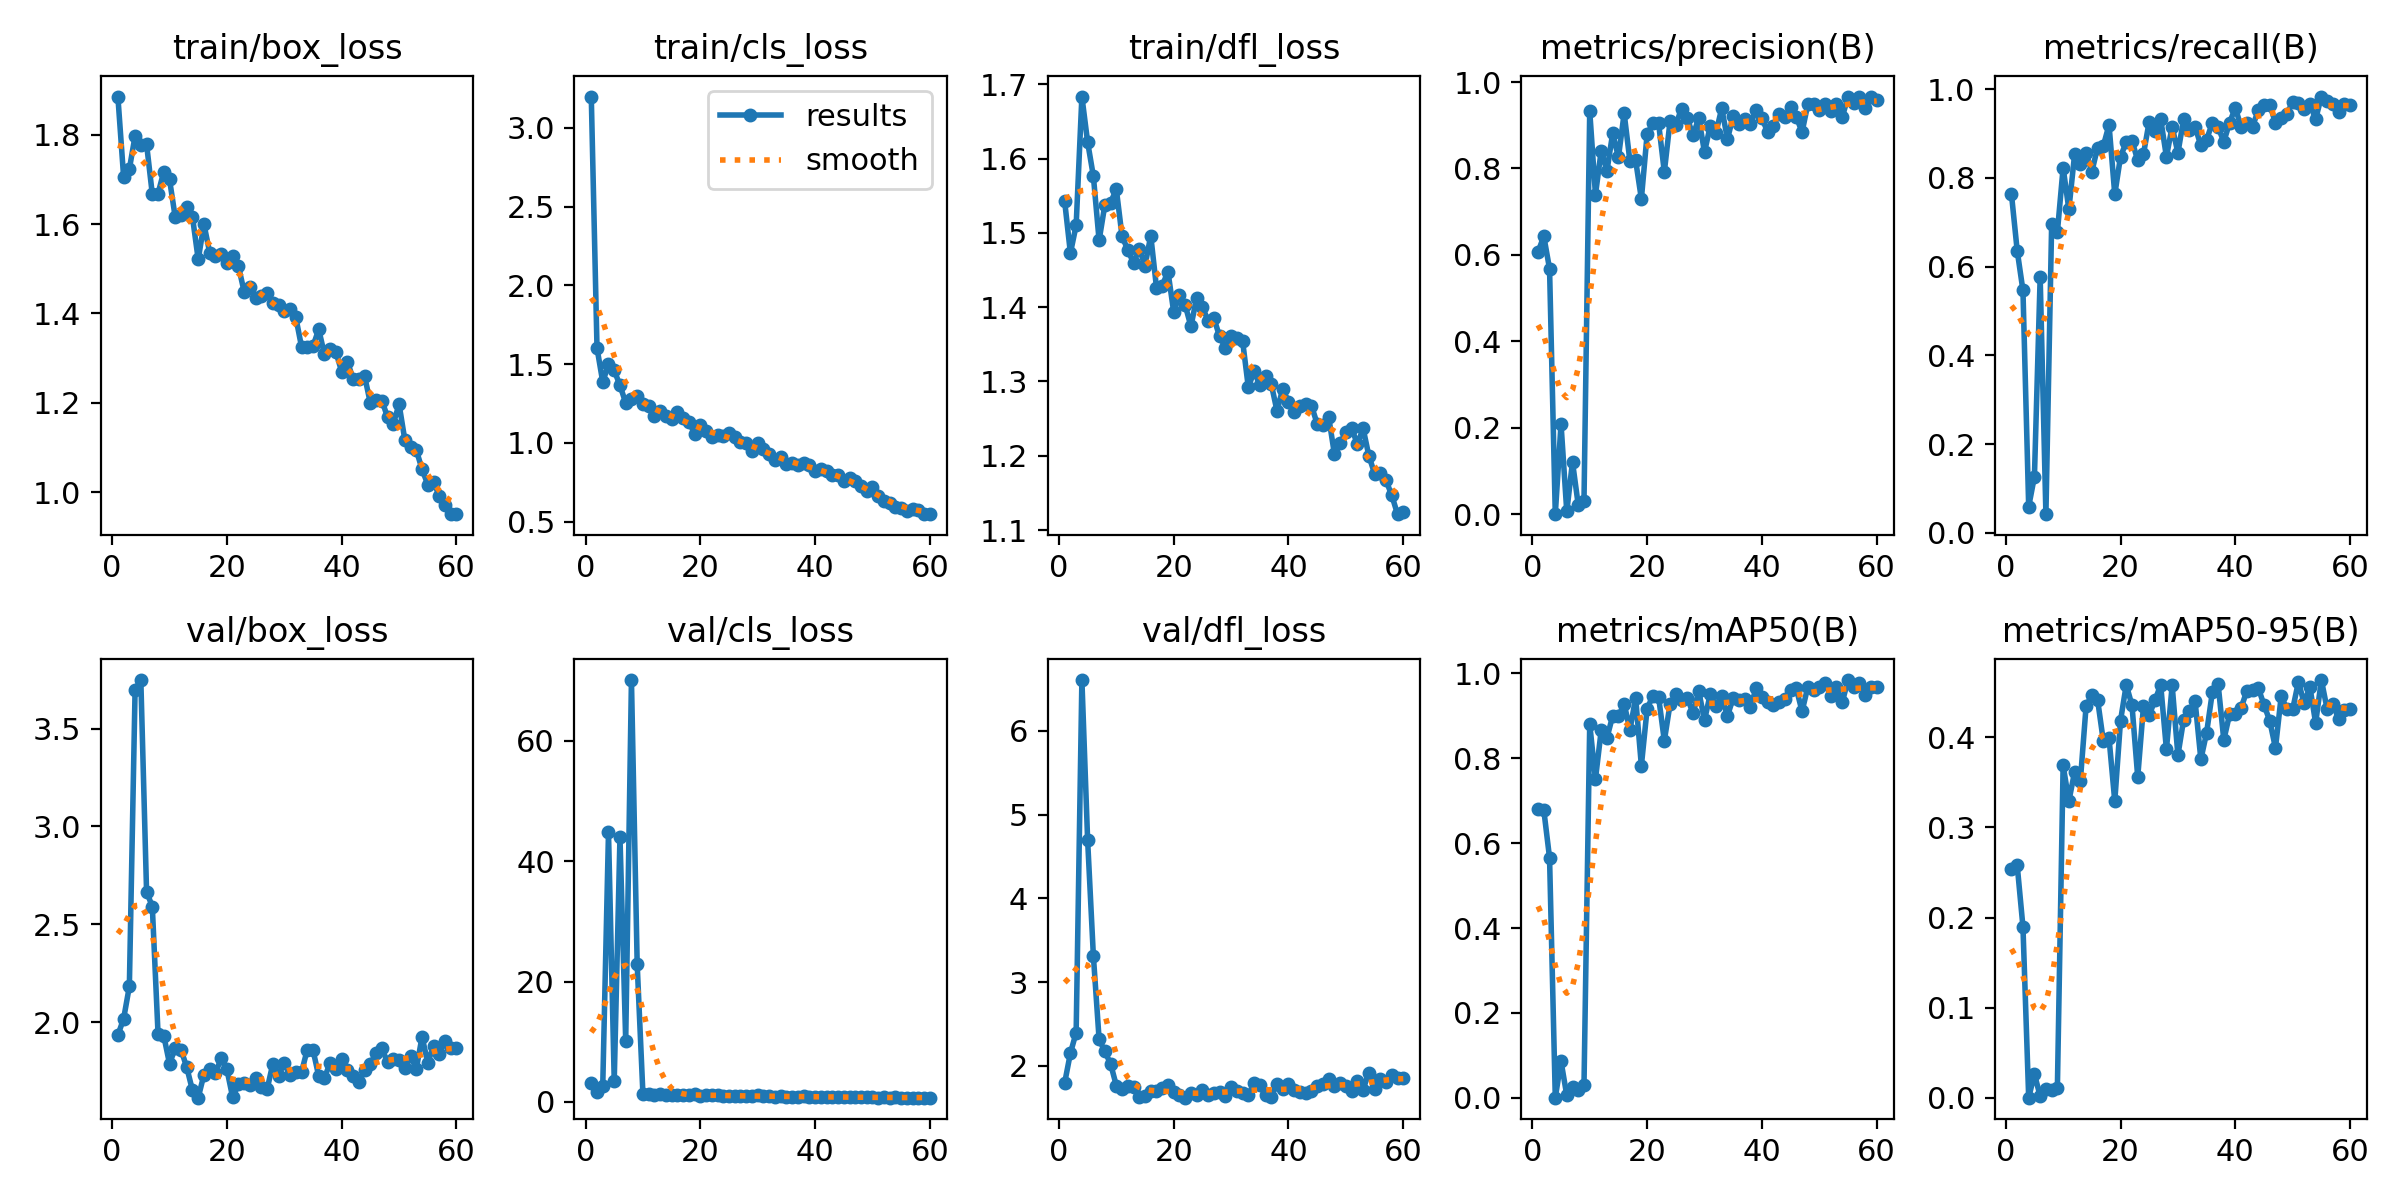

In [15]:
from IPython.display import Image
Image(filename="/content/runs/detect/train/results.png", width=600)

validate

In [16]:
!yolo task=detect mode=val model=/content/runs/detect/train/weights/best.pt data=/content/Number-Plate-Detection-1/data.yaml

Ultralytics 8.3.62 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/Number-Plate-Detection-1/valid/labels.cache... 118 images, 0 backgrounds, 0 corrupt: 100% 118/118 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 8/8 [00:02<00:00,  2.98it/s]
                   all        118        118      0.965      0.983      0.984      0.463
Speed: 1.2ms preprocess, 6.2ms inference, 0.0ms loss, 7.5ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


In [19]:
# prompt: how to preddict a new image using this model?

from IPython.display import Image

# Replace 'path/to/your/image.jpg' with the actual path to your image file
!yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt conf=0.25 source=/content/test1.jpeg save=True



Ultralytics 8.3.62 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs

image 1/1 /content/test1.jpeg: 320x416 1 number-plate, 37.6ms
Speed: 1.6ms preprocess, 37.6ms inference, 579.3ms postprocess per image at shape (1, 3, 320, 416)
Results saved to runs/detect/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict


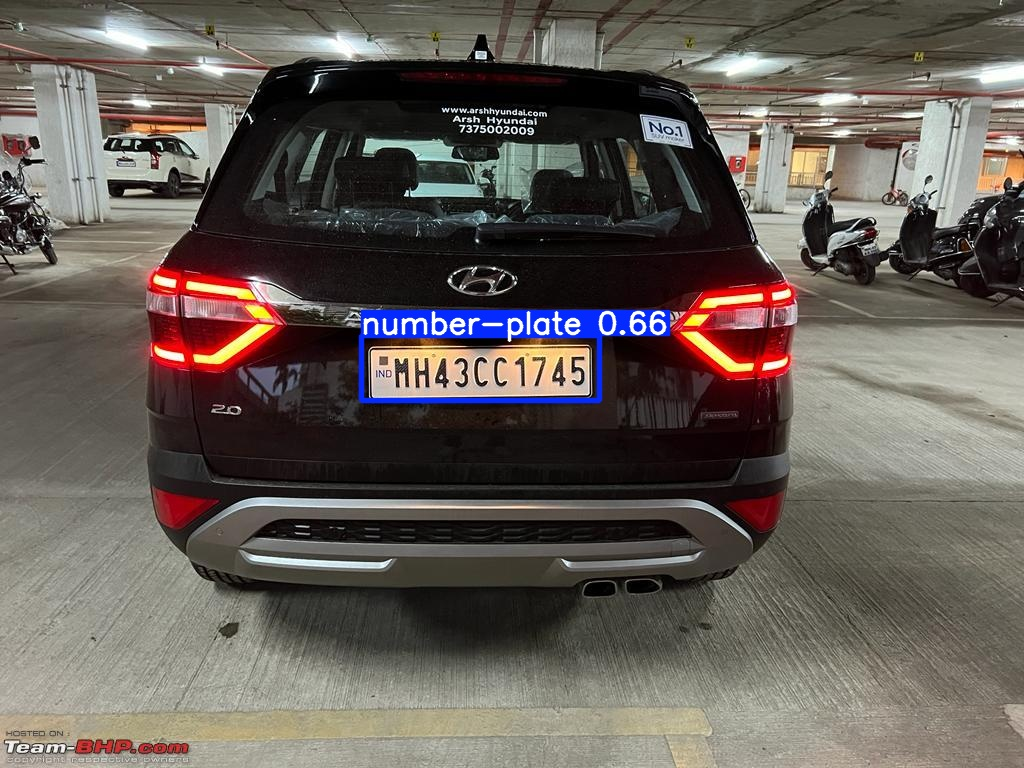

In [20]:
Image(filename="/content/runs/detect/predict2/test1.jpg", width=600)

In [21]:
project.version(dataset.version).deploy(model_type="yolov8", model_path="/content/runs/detect/train")

Dependency ultralytics==8.0.196 is required but found version=8.3.62, to fix: `pip install ultralytics==8.0.196`
Would you like to continue with the wrong version of ultralytics? y/n: y
View the status of your deployment at: https://app.roboflow.com/thrisha/number-plate-detection-wzc7s/1
Share your model with the world at: https://universe.roboflow.com/thrisha/number-plate-detection-wzc7s/model/1


In [22]:
!yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt conf=0.25 source=/content/t2.jpg save=True

Ultralytics 8.3.62 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs

image 1/1 /content/t2.jpg: 288x416 1 number-plate, 36.9ms
Speed: 2.1ms preprocess, 36.9ms inference, 573.8ms postprocess per image at shape (1, 3, 288, 416)
Results saved to runs/detect/predict3
💡 Learn more at https://docs.ultralytics.com/modes/predict


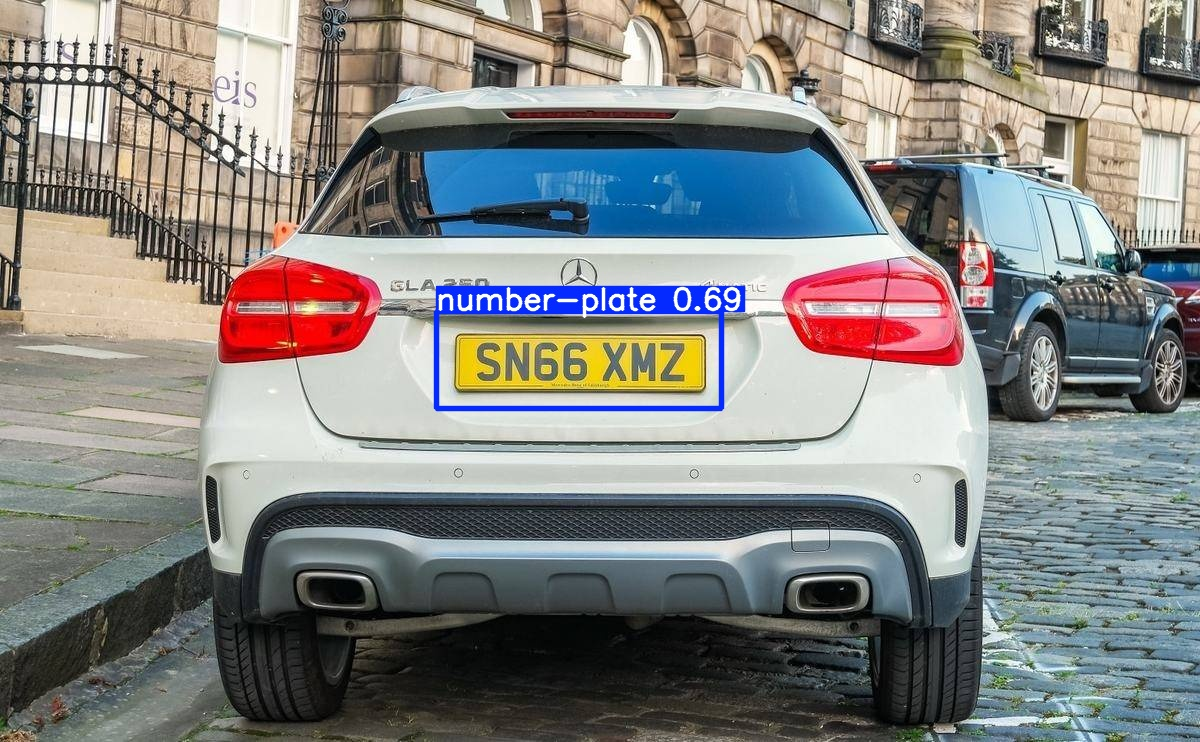

In [23]:
Image(filename="/content/runs/detect/predict3/t2.jpg", width=600)